[I 2025-02-25 18:53:48,319] A new study created in memory with name: no-name-925c421d-7efe-41e3-b990-ea607de6296a


   Run     A    B    C    D    E  PC-CONV-A  PC-CONV-B  yield-A  yield-B
0     1  140  2.5  433  240  300       73.0       70.3     70.0     67.7
1     2   14  1.5  433  240  400       49.0       47.6     48.0     46.7
2     3   10  2.5  433  120  300       35.5       38.0     33.7     35.6
3     4   10  2.5  433  240  400       76.2       76.2     72.2     72.2
4     5   10  2.5  463  240  500       69.5       67.2     67.3     64.8


[I 2025-02-25 18:53:48,634] Trial 0 finished with value: 14.80169332777688 and parameters: {'n_estimators': 193, 'max_depth': 10, 'learning_rate': 0.2892054365705064, 'subsample': 0.8928864090342019, 'colsample_bytree': 0.9617116127620204}. Best is trial 0 with value: 14.80169332777688.
[I 2025-02-25 18:53:48,702] Trial 1 finished with value: 55.11883228154981 and parameters: {'n_estimators': 63, 'max_depth': 8, 'learning_rate': 0.04162205680977181, 'subsample': 0.9925276827420231, 'colsample_bytree': 0.8384598495877751}. Best is trial 0 with value: 14.80169332777688.
[I 2025-02-25 18:53:48,803] Trial 2 finished with value: 24.409373409813398 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.22567879062694002, 'subsample': 0.6440064809192159, 'colsample_bytree': 0.7920825548463416}. Best is trial 0 with value: 14.80169332777688.
[I 2025-02-25 18:53:48,931] Trial 3 finished with value: 22.629935008232383 and parameters: {'n_estimators': 192, 'max_depth': 8, 'learn

Best Parameters: {'n_estimators': 174, 'max_depth': 3, 'learning_rate': 0.28180530129160636, 'subsample': 0.7304835330242041, 'colsample_bytree': 0.8289838703177929}
Train Mean Squared Error (MSE): 0.0001, Train R² Score: 1.0000
Test Mean Squared Error (MSE): 10.3972, Test R² Score: 0.9820


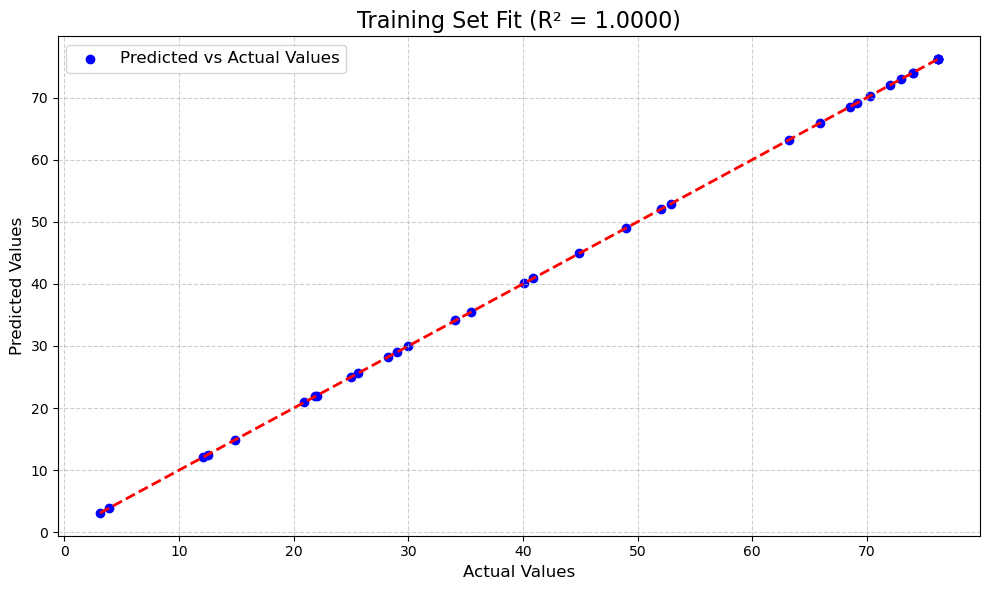

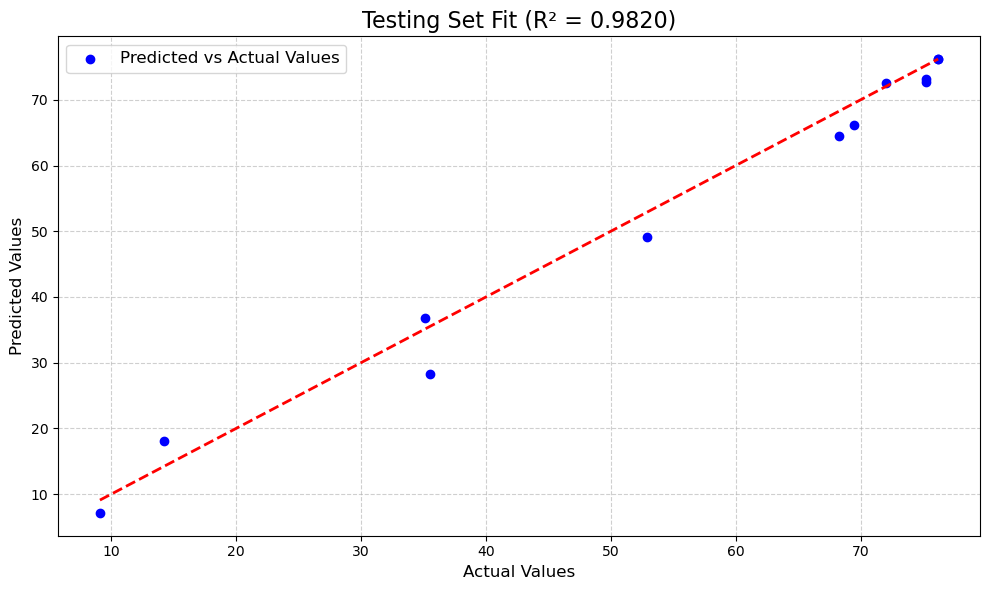

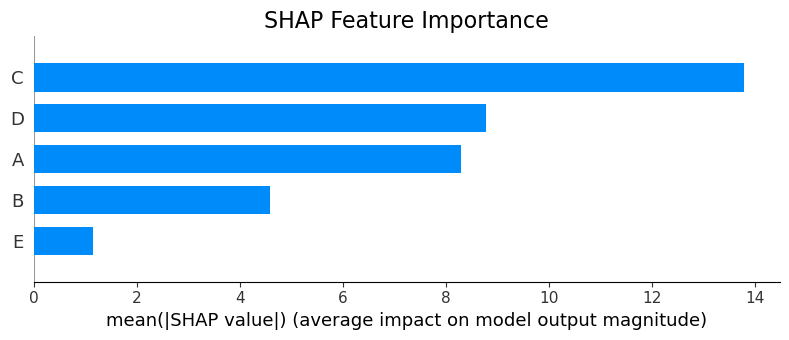

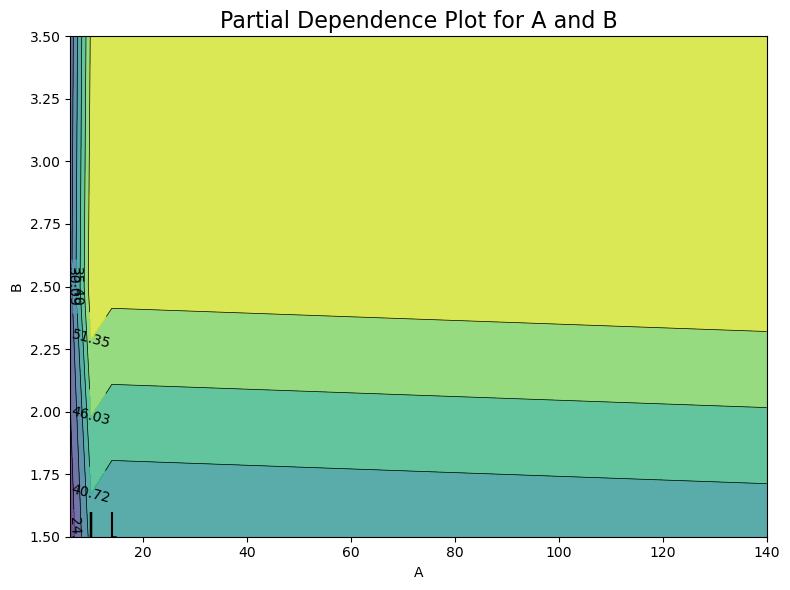

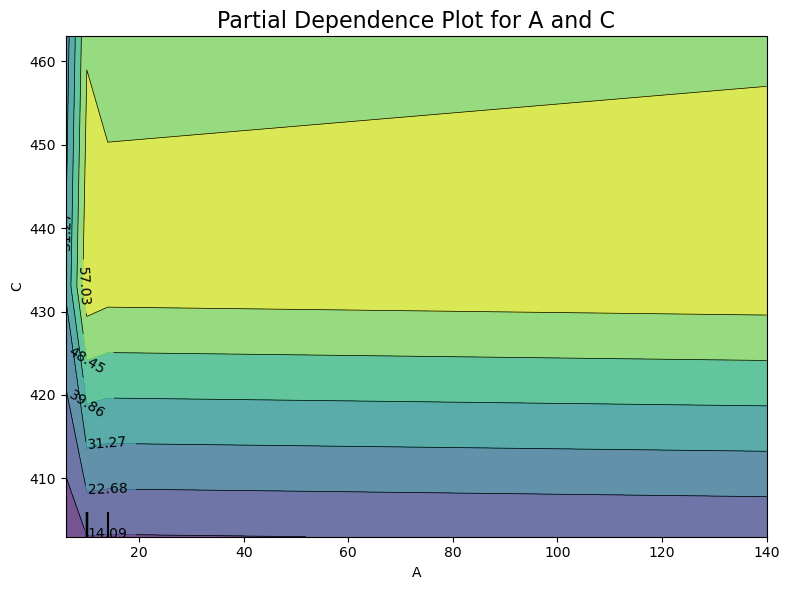

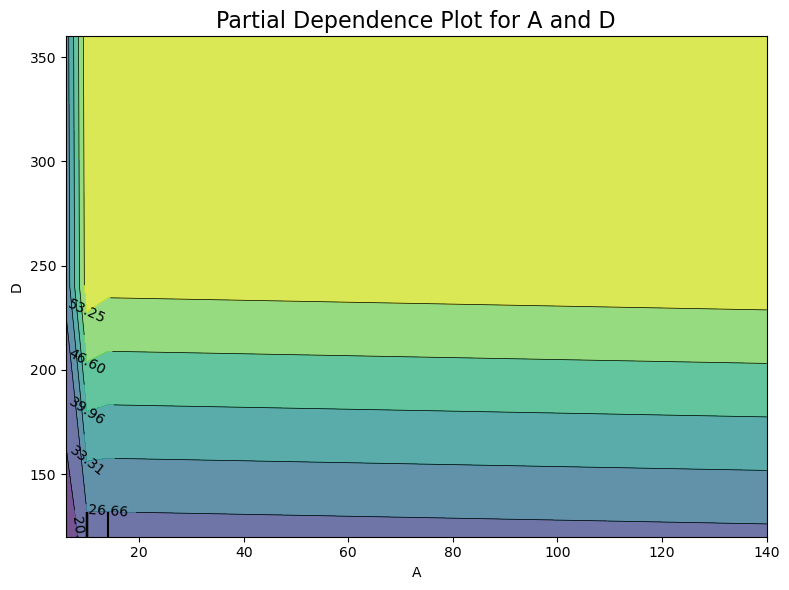

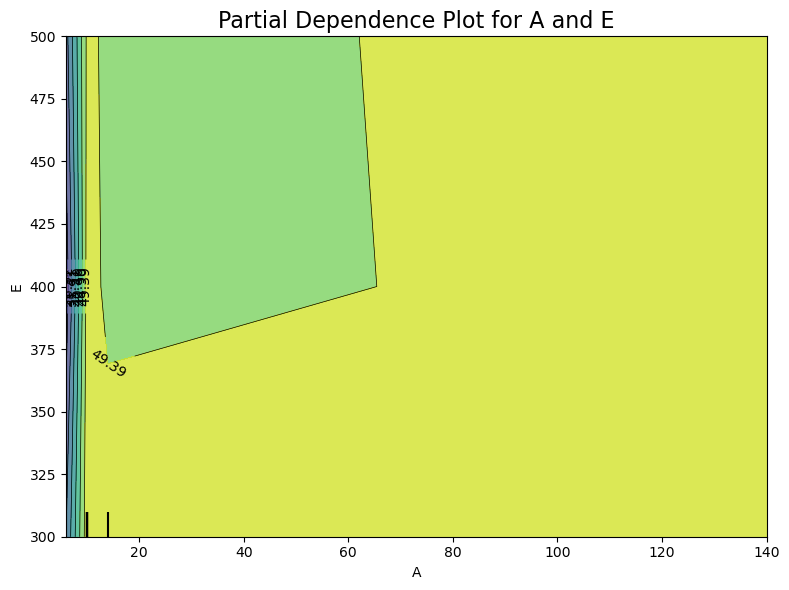

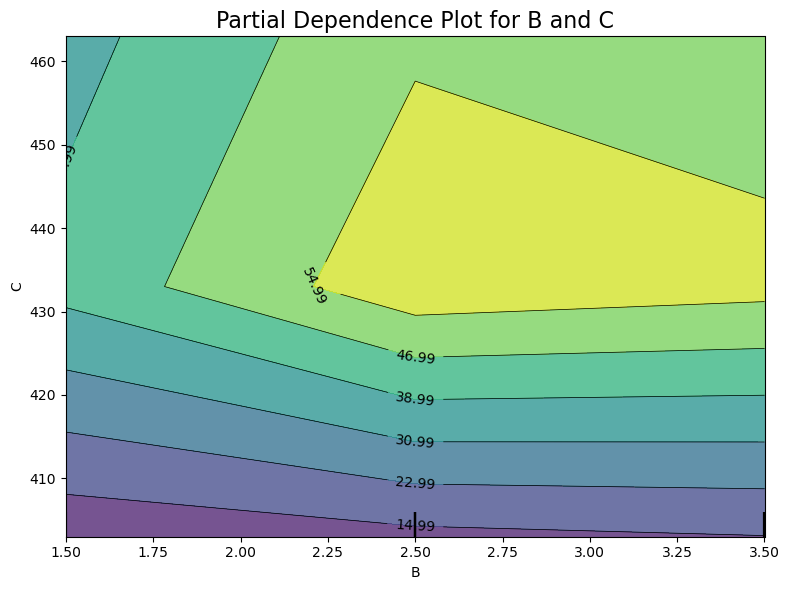

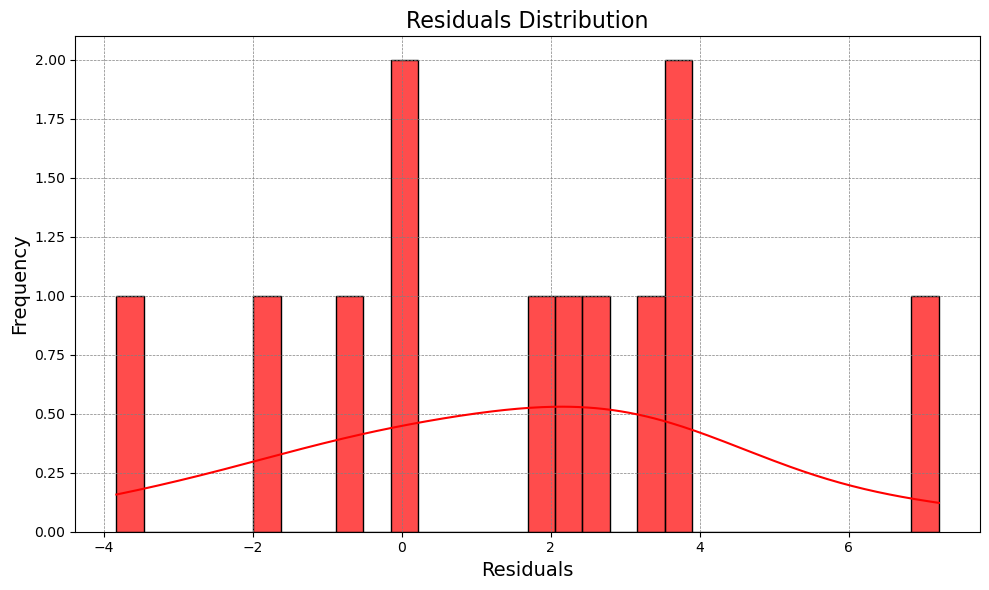

Best parameters found:  {'A': 76.96056001761234, 'B': 7.720088527511554, 'C': 438.9216040270105, 'D': 453.165683354836, 'E': 492.2261763372939}
Best predicted function value:  73.24916076660156


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from itertools import combinations
import optuna 
import shap  
import GPyOpt

file_path = '论文数据 - 副本.xlsx' 
data = pd.read_excel(file_path)
print(data.head())
X = data.iloc[:, 1:6]  
y = data.iloc[:, 6]  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42
    }
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
print("Best Parameters:", study.best_params)

best_model = XGBRegressor(**study.best_params, random_state=42)
best_model.fit(X_train, y_train)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train Mean Squared Error (MSE): {train_mse:.4f}, Train R² Score: {train_r2:.4f}")
print(f"Test Mean Squared Error (MSE): {test_mse:.4f}, Test R² Score: {test_r2:.4f}")

def plot_fit(actual, predicted, title, r2):
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predicted, color='blue', label='Predicted vs Actual Values')
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--', linewidth=2)
    plt.title(title + f" (R² = {r2:.4f})", fontsize=16)
    plt.xlabel('Actual Values', fontsize=12)
    plt.ylabel('Predicted Values', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_fit(y_train, y_train_pred, "Training Set Fit", train_r2)
plot_fit(y_test, y_test_pred, "Testing Set Fit", test_r2)

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, feature_names=X.columns, plot_type="bar", show=False)
plt.title('SHAP Feature Importance', fontsize=16)
plt.tight_layout()
plt.show()

features_to_plot = list(combinations(range(X_train.shape[1]), 2))[:5]

for feature_pair in features_to_plot:
    fig, ax = plt.subplots(figsize=(8, 6))
    display = PartialDependenceDisplay.from_estimator(
        best_model, X_train, [feature_pair], feature_names=X.columns, grid_resolution=50, ax=ax
    )
    ax.set_title(f'Partial Dependence Plot for {X.columns[feature_pair[0]]} and {X.columns[feature_pair[1]]}', fontsize=16)
    ax.set_xlabel(f'{X.columns[feature_pair[0]]}', fontsize=14)
    ax.set_ylabel(f'{X.columns[feature_pair[1]]}', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
    plt.tight_layout()
    plt.show()

residuals = y_test - y_test_pred

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color='red', alpha=0.7)
plt.title('Residuals Distribution', fontsize=16)
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.tight_layout()
plt.show()

def objective(x):
    A, B, C, D, E = x[0, 0], x[0, 1], x[0, 2], x[0, 3], x[0, 4]
    x_input = np.atleast_2d([A, B, C, D, E])
    prediction = best_model.predict(x_input)
    if isinstance(prediction, np.ndarray) and prediction.shape == (1,):
        prediction = prediction[0]
    return -prediction

bounds = [
    {'name': 'A', 'type': 'continuous', 'domain': (6, 200)},
    {'name': 'B', 'type': 'continuous', 'domain': (1.5, 10)},
    {'name': 'C', 'type': 'continuous', 'domain': (300, 700)},
    {'name': 'D', 'type': 'continuous', 'domain': (120, 700)},
    {'name': 'E', 'type': 'continuous', 'domain': (400, 600)}
]

initial_X = np.array([[6, 1.5, 300, 120, 400]])

optimizer = GPyOpt.methods.BayesianOptimization(
    f=objective,
    domain=bounds,
    acquisition_type='EI',
    X=initial_X,
    Y=None
)

max_iter = 50
optimizer.run_optimization(max_iter=max_iter)

best_params = optimizer.x_opt
best_value = -optimizer.fx_opt

print("Best parameters found: ", dict(zip([bound['name'] for bound in bounds], best_params)))
print("Best predicted function value: ", best_value)